In [2]:
import os
import numpy as np
import torch
import glob  ## finds all the pathnames matching a specified pattern
import torch.nn as nn   # helps build neural network models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable   ## for automatic differentiation that performs back propagation
import torchvision
import pathlib   #  provides various classes representing file system paths with semantics appropriate for different operating systems

In [2]:
model_dir = '/Users/risal/My_Codes/Projectdataminor/traintestsplit'
os.chdir(model_dir)

In [3]:
# check whcih  device to train is available
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device , "is available")
torch.cuda.empty_cache()

cuda is available


In [4]:
trnsfrm=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    # added --
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
   #--
    transforms.ToTensor(),  # conversion of  numpy to tensors, since pytorch processes data in tensors
    transforms.Normalize([0.5,0.5,0.5], # normalize using mean and standard deviation
                        [0.5,0.5,0.5])
])

In [5]:
## training and testing directory path
# C:\Users\risal\My_Codes\Projectdataminor\traintestsplit\Dataset\train
train_path='/Users/risal/My_Codes/Projectdataminor/traintestsplit/DataSet/train'
# val_path='/Users/risal/My_Codes/Projectdataminor/CrossValidation/birdsDataSet/Dataset/val'

In [6]:
# Pytorch  Dataloader

full_data_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=trnsfrm),
    batch_size=32, shuffle=True
)


In [7]:
import torch
from torchvision import datasets

# Load the dataset without normalization

data = next(iter(full_data_loader))
images, _ = data
mean = torch.mean(images, dim=(0, 2, 3))
std = torch.std(images, dim=(0, 2, 3))

print("Mean:", mean)
print("Std:", std)


Mean: tensor([-0.0052, -0.0704, -0.3039])
Std: tensor([0.5252, 0.5022, 0.4682])


In [8]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
# Add unique labels to the classes
class_labels = {label: i for i, label in enumerate(classes)}

# Print the class labels
print(class_labels)
# print(classes)

{'Abbott’s Babbler Malacocincla abbotti': 0, 'Black Bittern (Dupetor flavicollis)': 1, 'Blue-eared Kingfisher Alcedo meninting': 2, 'Blue-naped Pitta Pitta nipalensis': 3, 'Broad-billed Warbler Tickellia hodgsoni': 4, 'Cheer Pheasant (Catreus wallichii)': 5, 'Chestnut Munia Lonchura atricapilla': 6, 'Cinereous Vulture Aegypius monachus': 7, 'Golden Babbler Stachyris chrysaea': 8, 'Gould’s Shortwing Brachypteryx stellata': 9, 'Great Bittern Botaurus stellaris': 10, 'Great Hornbill (Buceros bicornis)': 11, 'Great Slaty Woodpecker Mulleripicus pulverulentus': 12, 'Ibisbill Ibidorhyncha struthersii': 13, 'Indian Courser Cursorius coromandelicus': 14, 'Indian Grassbird - Graminicola bengalensis': 15, 'Indian Nightjar Caprimulgus asiaticus': 16, 'Knob-billed Duck Sarkidiornis melanotos': 17, 'Northern Pintail Anas acuta': 18, 'Painted Stork Mycteria leucocephala': 19, 'Purple Cochoa Cochoa purpurea': 20, 'Red-headed Trogon Harpactes erythrocephalus': 21, 'Red-headed Vulture Sarcogyps calvus'

In [9]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes=38, kernel_size_conv1=3, in_channels=3,
                 out_channels_conv1=12, out_channels_conv2=20, kernel_size_conv2=3,
                 out_channels_conv3=32, kernel_size_conv3=3, num_features_batchnorm=32,
                 kernel_size_maxpool=2, dropout_prob=0.3):
        super(ConvNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels_conv1,
                               kernel_size=kernel_size_conv1, stride=1, padding=1)
        self.btch1 = nn.BatchNorm2d(num_features=out_channels_conv1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=kernel_size_maxpool)

        self.conv2 = nn.Conv2d(in_channels=out_channels_conv1, out_channels=out_channels_conv2,
                               kernel_size=kernel_size_conv2, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.conv3 = nn.Conv2d(in_channels=out_channels_conv2, out_channels=out_channels_conv3,
                               kernel_size=kernel_size_conv3, stride=1, padding=1)
        self.btch3 = nn.BatchNorm2d(num_features=out_channels_conv3)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Regularization drop_out

        # Fully connected layer
        self.fc = nn.Linear(in_features=75 * 75 * out_channels_conv3, out_features=num_classes)

    def forward(self, input):
        # Convolutional layers
        ot_put = self.conv1(input)
        ot_put = self.btch1(ot_put)
        ot_put = self.relu1(ot_put)
        ot_put = self.pool(ot_put)

        ot_put = self.conv2(ot_put)
        ot_put = self.relu2(ot_put)
        ot_put = self.dropout1(ot_put)

        ot_put = self.conv3(ot_put)
        ot_put = self.btch3(ot_put)
        ot_put = self.relu3(ot_put)
        ot_put = self.dropout2(ot_put)

        # Reshape and fully connected layer
        ot_put = ot_put.view(-1, 75 * 75 * 32)
        ot_put = self.fc(ot_put)

        return ot_put


In [10]:
mdl= ConvNet(num_classes=38).to(device)
optimizer=Adam(mdl.parameters(),lr=0.0001,weight_decay=0.001)
loss_function=nn.CrossEntropyLoss()
num_epochs=10

In [11]:
# Total size of training and testing images
train_count=len(glob.glob(train_path+'/**/*'))
# val_count=len(glob.glob(val_path+'/**/*'))
print(train_count)# Total size of training and testing images

8073


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Assuming you have the DataLoader for your entire dataset called 'full_data_loader'

# Number of folds for cross-validation
num_folds = 10

# Initialize StratifiedKFold with the number of folds
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store accuracy and loss values for each fold
all_train_accuracy = []
all_train_loss = []
all_val_accuracy = []
all_val_loss = []

# Early stopping parameters
early_stop_patience = 3  # Number of epochs without improvement to wait before early stopping
early_stop_counter = 0

best_val_loss = float('inf')

# K-fold Cross-validation loop
for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(full_data_loader.dataset)), full_data_loader.dataset.targets)):
    print(f"\nFold {fold + 1}/{num_folds}")

    # Create data loaders for training and validation using indices from the current fold
    train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(full_data_loader.dataset, train_indices), batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(full_data_loader.dataset, val_indices), batch_size=32, shuffle=False)

    # Training loop
    for epoch in range(num_epochs):
        mdl.train()
        train_accuracy = 0.0
        train_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            optimizer.zero_grad()

            outputs = mdl(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))

        train_accuracy = train_accuracy / len(train_indices)
        train_loss = train_loss / len(train_indices)

        # Validation loop
        mdl.eval()
        val_accuracy = 0.0
        val_loss = 0.0

        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            outputs = mdl(images)
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))
            val_loss += loss_function(outputs, labels).cpu().item() * images.size(0)

        val_accuracy = val_accuracy / len(val_indices)
        val_loss = val_loss / len(val_indices)

        print(f'Fold {fold + 1}/{num_folds}, Epoch: {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}, Val Loss: {val_loss}')

        # Append accuracy and loss values to the lists
        all_train_accuracy.append(train_accuracy)
        all_train_loss.append(train_loss)
        all_val_accuracy.append(val_accuracy)
        all_val_loss.append(val_loss)

        if val_loss < best_val_loss:
            early_stop_counter = 0  # Reset the counter when there's an improvement
            best_val_loss = val_loss
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break
        

# Plotting the train and val loss
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss vs. Epochs')
plt.legend()

# Plotting the train and val accuracy in one graph
plt.subplot(1, 2, 2)
plt.plot(all_train_accuracy, label='Train Accuracy')
plt.plot(all_val_accuracy, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Val Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
torch.save(mdl.state_dict(), "best_cHpnt10fld500.pth")

In [ ]:
print(mdl.state_dict())

OrderedDict({'conv1.weight': tensor([[[[ 0.1468, -0.0258, -0.1411],
          [-0.1107, -0.1083,  0.1798],
          [ 0.0034,  0.0546,  0.0722]],

         [[ 0.0795, -0.0262,  0.0602],
          [-0.0949,  0.1697, -0.0841],
          [-0.0139,  0.0022, -0.0225]],

         [[ 0.1661, -0.0379, -0.1568],
          [-0.1590,  0.0490,  0.0383],
          [ 0.0983,  0.1202,  0.0937]]],


        [[[-0.1445, -0.0046,  0.0272],
          [ 0.0413,  0.1167,  0.0642],
          [-0.0186, -0.1735, -0.0467]],

         [[-0.0131, -0.0071,  0.0220],
          [ 0.0757, -0.1898, -0.0011],
          [ 0.1325, -0.0960,  0.0339]],

         [[ 0.1644,  0.1260,  0.1693],
          [ 0.2033, -0.0013,  0.1712],
          [ 0.0465,  0.1863,  0.0638]]],


        [[[ 0.1278, -0.1391,  0.1843],
          [ 0.1261, -0.0072, -0.0792],
          [ 0.0948,  0.0371, -0.1604]],

         [[-0.1625, -0.0100,  0.1193],
          [ 0.1839, -0.0830,  0.1461],
          [-0.1213, -0.0375,  0.0834]],

         [[-0.0

Testing


In [13]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

In [14]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device , "is available")

cuda is available


In [15]:
#Transform test data
trnsfrm=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5],
                        [0.5,0.5,0.5])
    ])

In [16]:
checkpoint=torch.load("best_cHpnt10fld500.pth")
mdl=ConvNet(num_classes=38).to(device) # num_classes 38 huna parxa
mdl.load_state_dict(checkpoint)
# torch.load(model.state_dict(), os.path.join(
#                         model_dir, "/Users/risal/My_Codes/Projectdataminor/traintestsplit/checkpoint10.pth"))
mdl.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=180000, out_features=38, bias=True)
)

In [17]:
print(mdl.state_dict())

OrderedDict({'conv1.weight': tensor([[[[ 0.1468, -0.0258, -0.1411],
          [-0.1107, -0.1083,  0.1798],
          [ 0.0034,  0.0546,  0.0722]],

         [[ 0.0795, -0.0262,  0.0602],
          [-0.0949,  0.1697, -0.0841],
          [-0.0139,  0.0022, -0.0225]],

         [[ 0.1661, -0.0379, -0.1568],
          [-0.1590,  0.0490,  0.0383],
          [ 0.0983,  0.1202,  0.0937]]],


        [[[-0.1445, -0.0046,  0.0272],
          [ 0.0413,  0.1167,  0.0642],
          [-0.0186, -0.1735, -0.0467]],

         [[-0.0131, -0.0071,  0.0220],
          [ 0.0757, -0.1898, -0.0011],
          [ 0.1325, -0.0960,  0.0339]],

         [[ 0.1644,  0.1260,  0.1693],
          [ 0.2033, -0.0013,  0.1712],
          [ 0.0465,  0.1863,  0.0638]]],


        [[[ 0.1278, -0.1391,  0.1843],
          [ 0.1261, -0.0072, -0.0792],
          [ 0.0948,  0.0371, -0.1604]],

         [[-0.1625, -0.0100,  0.1193],
          [ 0.1839, -0.0830,  0.1461],
          [-0.1213, -0.0375,  0.0834]],

         [[-0.0

In [18]:
mdl.to(device)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (btch3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=180000, out_features=38, bias=True)
)

In [19]:
def prediction(img_path, trnsfrm, mdl, class_labels, device):
    try:
        image = Image.open(img_path).convert('RGB')
        image_tensor = trnsfrm(image).float()
        image_tensor = image_tensor.unsqueeze_(0)

        image_tensor = image_tensor.to(device)  # Move tensor to device

        output = mdl(image_tensor)
        _, index = output.data.cpu().max(1)  # Get the index of the max log-probability
        label_index = index.item()

        # Convert label index to the corresponding label
        pred_label = list(class_labels.values())[list(class_labels.values()).index(label_index)]

        return pred_label
    except Exception as e:
        print(f"Error during prediction for image {img_path}: {str(e)}")
        return None

In [20]:
# C:\Users\risal\My_Codes\Projectdataminor\traintestsplit\Dataset\pred
images_path=glob.glob('/Users/risal/My_Codes/Projectdataminor/traintestsplit/Dataset/pred/*')
# test_loader = DataLoader(images_path, shuffle=True, batch_size=32)

In [21]:
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/') + 1:]] = prediction(i, trnsfrm, mdl, class_labels, device)
    

In [22]:
pred_dict

{'pred\\Abbott’s Babbler Malacocincla abbotti 106.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 136.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 140.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 21.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 36.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 51.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 8.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 95.jpg': 0,
 'pred\\Black Bittern (Dupetor flavicollis) 11.png': 35,
 'pred\\Black Bittern (Dupetor flavicollis) 12.png': 10,
 'pred\\Black Bittern (Dupetor flavicollis) 14.png': 1,
 'pred\\Black Bittern (Dupetor flavicollis) 152.png': 1,
 'pred\\Black Bittern (Dupetor flavicollis) 159.png': 1,
 'pred\\Black Bittern (Dupetor flavicollis) 184.png': 19,
 'pred\\Black Bittern (Dupetor flavicollis) 199.png': 5,
 'pred\\Black Bittern (Dupetor flavicollis) 217.png': 29,
 'pred\\Black Bittern (Dupetor flavicollis) 226.png': 31,
 'pred\\Black Bitte

In [23]:
# Assuming you have the prediction mapping dictionary
prediction_mapping = {
    0: 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर',
    1: 'Black Bittern (Dupetor flavicollis) = कालो जूनबकुल्ला',
    2: 'Blue-eared Kingfisher Alcedo meninting = ',
    3: 'Blue-naped Pitta Pitta nipalensis = ',
    4: 'Broad-billed Warbler Tickellia hodgsoni',
    5: 'Cheer Pheasant (Catreus wallichii) = Cheer Kaliz',
    6: 'Chestnut Munia Lonchura atricapilla = कोटेरो मुनियाँ',
    7: 'Cinereous Vulture Aegypius monachus = राज गिद्ध',
    8: 'Golden Babbler Stachyris chrysaea = NO Name',
    9: 'Gould’s Shortwing Brachypteryx stellata = थोप्ले लघुपंख',
    10: 'Great Bittern Botaurus stellaris = कालो जूनबकुल्ला',
    11: 'Great Hornbill (Buceros bicornis) = राजधनेश',
    12: 'Great Slaty Woodpecker Mulleripicus pulverulentus',
    13: 'Ibisbill Ibidorhyncha struthersii = तिलहरी चरा',
    14: 'Indian Courser Cursorius coromandelicus = गाजले धावक',
    15: 'Indian Grassbird - Graminicola bengalensis',
    16: 'Indian Nightjar Caprimulgus asiaticus = चुकचुके चैतेचरा',
    17: 'Knob-billed Duck Sarkidiornis melanotos = नकटा',
    18: 'Northern Pintail Anas acuta = सुइरोपुछ्रे',
    19: 'Painted Stork Mycteria leucocephala = लालटाउके गरुड',
    20: 'Purple Cochoa Cochoa purpurea = बैजनी कचोवा',
    21: 'Red-headed Trogon Harpactes erythrocephalus = रक्त्त शिर',
    22: 'Red-headed Vulture Sarcogyps calvus = सुन गिद्ध',
    23: 'Red-necked Falcon Falco chicquera = रातोटाउके बौँडाइ',
    24: 'Ruby-cheeked Sunbird Anthreptes singalensis = प्याजीकाने बुङ्गेचरा',
    25: 'Rusty-fronted Barwing Actinodura egertoni = कैलोतालु वनचाहर',
    26: 'Saker Falcon Falco cherrug = तोप बाज',
    27: 'Silver-eared Mesia Leiothrix argentauris = चाँदीकाने मिसीया',
    28: 'Slaty-legged Crake Rallina eurizonoides = देउकौवा',
    29: 'Spot-bellied Eagle Owl Bubo nipalensis = महाकौशिक',
    30: 'Sultan Tit Melanochlora sultanea = स्वर्णचूल राजचिचिल्कोटे',
    31: 'Swamp Francolin Francolinus gularis = सिमतित्रा',
    32: 'Tawny-bellied Babbler Dumetia hyperythra = कैलो घाँसेभ्याकुर',
    33: 'Thick-billed Green Pigeon Treron curvirostra = मोटोठूँडे हलेसो',
    34: 'White-throated Bulbul Alophoixus flaveolus =  सेतोकण्ठे जुरेली',
    35: 'White-throated Bushchat Saxicola insignis = सेतोकण्ठे धिप्सी',
    36: 'Yellow-rumped Honeyguide - Indicator xanthonotus = पीतनिर्गम फिस्टो',
    37: 'Yellow-vented Warbler Phylloscopus cantator = मोटोठूँडे भ्याकुर'
}

# Map predicted labels to names using prediction_mapping dictionary
predicted_names = [prediction_mapping[label] for label in pred_dict.values()]

# Print or use the predicted names
print(predicted_names)


['Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर', 'White-throated Bushchat Saxicola insignis = सेतोकण्ठे धिप्सी', 'Great Bittern Botaurus stellaris = कालो जूनबकुल्ला', 'Black Bittern (Dupetor flavicollis) = कालो जूनबकुल्ला', 'Black Bittern (Dupetor flavicollis) = कालो जूनबकुल्ला', 'Black Bittern (Dupetor flavicollis) = कालो जूनबकुल्ला', 'Painted Stork Mycteria leucocephala = लालटाउके गरुड', 'Cheer Pheasant (Catreus wallic

In [24]:
pred_dict

{'pred\\Abbott’s Babbler Malacocincla abbotti 106.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 136.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 140.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 21.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 36.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 51.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 8.jpg': 0,
 'pred\\Abbott’s Babbler Malacocincla abbotti 95.jpg': 0,
 'pred\\Black Bittern (Dupetor flavicollis) 11.png': 35,
 'pred\\Black Bittern (Dupetor flavicollis) 12.png': 10,
 'pred\\Black Bittern (Dupetor flavicollis) 14.png': 1,
 'pred\\Black Bittern (Dupetor flavicollis) 152.png': 1,
 'pred\\Black Bittern (Dupetor flavicollis) 159.png': 1,
 'pred\\Black Bittern (Dupetor flavicollis) 184.png': 19,
 'pred\\Black Bittern (Dupetor flavicollis) 199.png': 5,
 'pred\\Black Bittern (Dupetor flavicollis) 217.png': 29,
 'pred\\Black Bittern (Dupetor flavicollis) 226.png': 31,
 'pred\\Black Bitte

In [25]:
test_path = '/Users/risal/My_Codes/Projectdataminor/traintestsplit/DataSet/test'

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=trnsfrm),
    batch_size=64, shuffle=True
)

In [26]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate metrics
confusion_matrix = ConfusionMatrix(num_classes=38, task="multiclass").to(device)

# Iterate through validation dataset
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = mdl(images)

    # Compute predictions
    _, preds = torch.max(outputs, dim=1)

    # Update confusion matrix
    confusion_matrix.update(preds, labels)

# Compute confusion matrix
cm = confusion_matrix.compute()

# Move the confusion matrix to CPU before converting to NumPy
cm = cm.cpu().numpy()

print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[8 0 0 ... 0 0 0]
 [0 4 0 ... 1 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 5]]


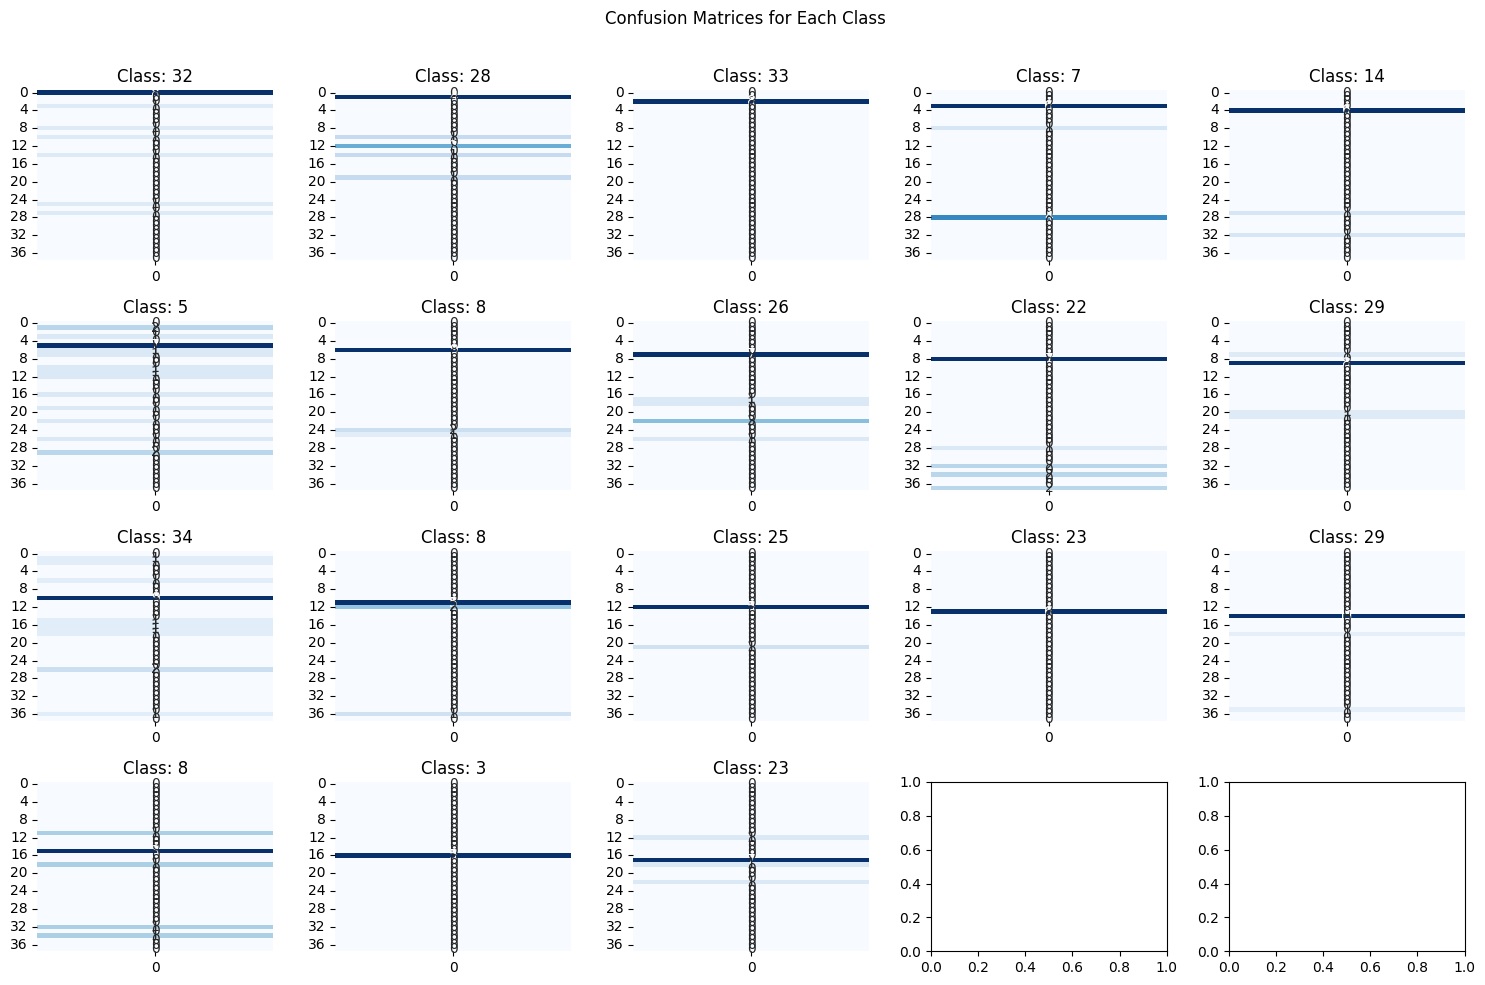

In [27]:

# Get class names
class_names = list(labels.cpu().numpy())

# Plot confusion matrix for each class
num_classes = len(class_names)
fig, axes = plt.subplots(nrows=int(np.ceil(num_classes/5)), ncols=5, figsize=(15, 3*num_classes//5))
fig.suptitle('Confusion Matrices for Each Class')

for i, class_name in enumerate(class_names):
    row = i // 5
    col = i % 5
    sns.heatmap(cm[:, i, np.newaxis], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
    axes[row, col].set_title(f'Class: {class_name}')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [30]:
import torch

# Assuming confusion_matrix is the tensor containing the confusion matrix
# Convert the confusion matrix tensor to a numpy array for easier manipulation
confusion_matrix_tensor = confusion_matrix.compute().cpu()

confusion_matrix_np = confusion_matrix_tensor.numpy()

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = np.diag(confusion_matrix_np).sum()
FP = np.sum(confusion_matrix_np, axis=0) - np.diag(confusion_matrix_np)
FN = np.sum(confusion_matrix_np, axis=1) - np.diag(confusion_matrix_np)
TN = np.sum(confusion_matrix_np) - (TP + FP + FN)

# Calculate accuracy and precision
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP/(TP +FN)
F1_SCORE = (int(2)*precision * recall)/(precision + recall)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1_score: {F1_SCORE}')


Accuracy: [0.98507463 0.96766169 0.99253731 0.9800995  0.99253731 0.95771144
 0.98507463 0.97263682 0.97512438 0.99253731 0.96766169 0.9800995
 0.9800995  0.99751244 0.99004975 0.98507463 0.9800995  0.98507463
 0.97761194 0.9800995  0.99253731 0.99502488 0.98507463 0.98756219
 0.98258706 0.96268657 0.96766169 0.98756219 0.98258706 0.98507463
 0.99502488 0.97263682 0.97263682 0.98258706 0.9800995  0.9800995
 0.98507463 0.98756219]
Precision: [0.97769517 0.98134328 1.         0.98134328 0.99245283 0.94945848
 0.9887218  0.97769517 0.97407407 0.9887218  0.96336996 0.9887218
 0.99621212 1.         0.99245283 0.98501873 1.         0.9887218
 0.99245283 0.97769517 0.99621212 1.         0.99621212 0.98501873
 0.98134328 0.97407407 0.97407407 0.99245283 0.99621212 0.9887218
 1.         0.96691176 0.9887218  0.99245283 0.98501873 0.97769517
 1.         0.99245283]
F1_score: [0.9887218  0.97588126 0.99432892 0.98501873 0.99432892 0.96869245
 0.9887218  0.97951583 0.98134328 0.99432892 0.97588126

In [31]:
# images_path=glob.glob('/Users/risal/My_Codes/Projectdataminor/traintestsplit/Dataset/newtest/*')# test image
# images_path=glob.glob('/Users/risal/My_Codes/Projectdataminor/traintestsplit/Dataset/train/Golden Babbler Stachyris chrysaea/Golden Babbler Stachyris chrysaea 1.png')# train image
images_path=glob.glob('/Users/risal/My_Codes/Projectdataminor/traintestsplit/Dataset/val/Abbott’s Babbler Malacocincla abbotti/Abbott’s Babbler Malacocincla abbotti 1.jpg')


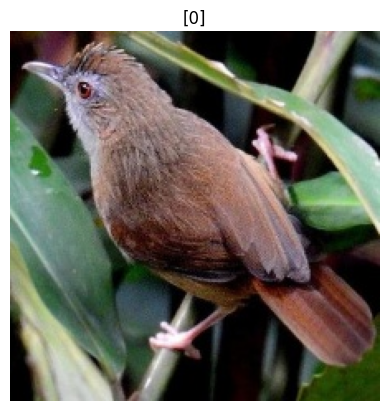

Abbott’s Babbler Malacocincla abbotti = मोटोठूँडे भ्याकुरमोटोठूँडे भ्याकुर


In [32]:
import matplotlib.pyplot as plt
# pred_dicto ={}
for i in images_path:
    pred_bird = prediction(i, trnsfrm, mdl, class_labels, device)
    
    # Load the image using PIL
    predicted_labels = [pred_bird ]
    prediction_names= prediction_mapping[pred_bird]
    image = Image.open(i)

    # Plot the image using matplotlib
    plt.imshow(image)
    plt.title(predicted_labels)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    print(prediction_names)
